In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import geopandas
import cartopy.io.shapereader as shpreader
import shapely

In [2]:
places = pd.read_csv('../data/place_df.csv')

import pycountry_convert as pc
def get_cont(x):
    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'
    }
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))]
    except:
        return None
places['continent'] = places.apply(lambda x: get_cont(x), axis=1)
other_country_continents = [
    ("ESH","Africa"),
    ("TLS","Oceania"),
    ("XKX","Europe")
    
]
for country,continent in other_country_continents:
    places.loc[places['country_predicted']==country,"continent"] = continent

degrees = 2.5
tdf = pd.read_csv(f'../data/study_da_6 - Temperature - upper_pred_{degrees}.csv')
tdf["da_var"] = "Temperature"
pdf = pd.read_csv(f'../data/study_da_6 - Precipitation - upper_pred_{degrees}.csv')
pdf["da_var"] = "Precipitation"

df = pd.concat([tdf,pdf])

df = df[pd.notna(df["gridcells"]) & df["gridcells"]>0]

df["da_trend_p"] = df["da_trend_cells"] / df["gridcells"]

df.shape

(37899, 236)

In [3]:
cat_df = pd.read_csv('../data/1_predicted_category_documents.csv')
predictions = pd.read_csv('../data/1_document_relevance.csv')
cat_df = cat_df.merge(cat_df.merge(predictions), how="left")

print(cat_df.shape)

#cat_df = cat_df[~cat_df['id'].isin(df['id'])]

cat_df['tp'] = np.where(cat_df['id'].isin(df['id']),0,1)

print(cat_df.shape)


# Merge actual and predicted categories
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction",
    "12 - Total"
]

(120265, 232)
(120265, 233)
4299.3941876741
4332.3941876741
5368.001105287318
5383.001105287318
3285.6511919414793
3339.673251435902
8248.421056475916
8309.421056475916
12781.964560849228
12839.964560849228
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']


In [4]:
sector_cols = [x for x in df.columns if "12 - " in x and " - upper_pred" in x]

In [5]:
ndf = pd.read_csv('../data/gridcell_studies_all_2.5.csv')
ndf.loc[ndf['LON']>180,"LON"]-=360
ndf.head()

,LAT,LON,n_studies,LAT_25,LON_25,da_cat,index,n_study_prop
0,-88.75,-178.75,0.0,-87.5,182.5,NaN,0,0.0
1,-88.75,-176.25,0.0,-87.5,182.5,NaN,1,0.0
2,-88.75,-173.75,0.0,-87.5,187.5,NaN,4,0.0
3,-88.75,-171.25,0.0,-87.5,187.5,NaN,5,0.0
4,-88.75,-168.75,0.0,-87.5,192.5,NaN,8,0.0


In [6]:
X, Y = np.meshgrid(
    list(ndf.LON.unique())+[ndf.LON.max()+degrees],   
    list(ndf.LAT.unique())+[ndf.LAT.max()+degrees], 
)
X.shape

(73, 145)

In [7]:
regions = [
    {"name": "Africa", "x": 0.51, "y": 0.47},
    {"name": "Asia", "x": 0.69, "y": 0.62},
    {"name": "Europe",    "x": 0.48,    "y": 0.68},
    {"name": "North America", "x": 0.26, "y": 0.69},
    {"name": "Oceania", "x": 0.79, "y": 0.38},
    {"name": "South America", "x": 0.31, "y": 0.47},
    
#     {"name": "Global or NA", "x": 0.44, "y": 0.29, "alpha":1}
]

South America
(0.32, 0.35)
North America
(0.3, 0.8)
Africa
(0.5, 0.6)
Europe
(0.52, 0.85)
Asia
(0.75, 0.75)
Oceania
(0.87, 0.33)


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


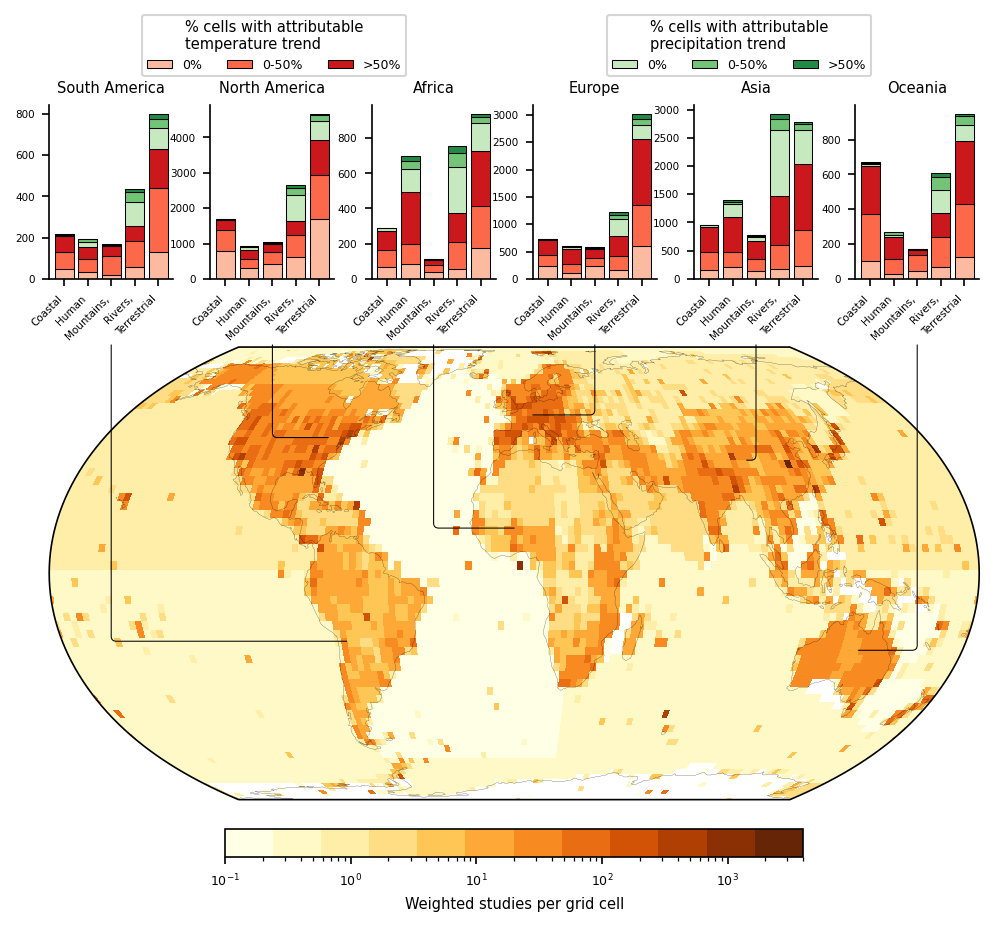

In [8]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch, ConnectionStyle

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.5

cols = 2

fig = plt.figure(dpi=150,figsize=(8,6))

gs = gridspec.GridSpec(3, 6, height_ratios=[.1, .3, 1,], bottom=.05, top=.95, wspace=.3, hspace=0.0)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X,
    Y,
    n,
    norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
    cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="horizontal", fraction=0.05, pad=0.05)

cbar.set_label("Weighted studies per grid cell", fontsize=7)
cbar.ax.tick_params(labelsize=6)

continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

continent_labels = [
    (0.32,0.35),
    (0.3,0.8),
    (0.5,0.6),
    (0.52,0.85),
    (0.75,0.75),
    (0.87,0.33),
]

#for ci, (continent, group) in enumerate(places.groupby('continent')):
    
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    r = regions[ci]
    a = plt.subplot(gs[1,ci])
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    
    xy = (0.5, -0.38)
    
    mxy = continent_labels[ci]
    print(mxy)
    con = ConnectionPatch(xyA=xy, coordsA=a.transAxes,
                          xyB=mxy, coordsB=ax.transAxes,
                          connectionstyle=ConnectionStyle.Angle(angleA=90, rad=5),
                          linewidth=0.5
                         )
    fig.add_artist(con)

    
    vdf = df[df["id"].isin(group["doc_id"])]
    
    for i, col in enumerate(sector_cols):

        b = 0
        all_handles = []
        for j, da_var in enumerate(["Temperature","Precipitation"]):

            cm = mpl.cm.get_cmap(colors[j])

            cdf = vdf[(vdf[col]>0.5) & (vdf["da_var"]==da_var) ]

            y = cdf[cdf['da_trend_p']==0].shape[0]
            l1 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
            b+=y

            y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
            l2 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
            b+=y

            y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
            l3 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
            b+=y
            
            var_handles = [l1,l2,l3]
            all_handles.append(var_handles)
            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)
    
ax = plt.subplot(gs[0,:])
attrib_labels = [
    "0%",
    "0-50%",
    ">50%"
]

l0 = ax.legend(
    all_handles[0], attrib_labels, 
    loc=(.1,0.5),
    fontsize=6,
    ncol=3
)    
l0.set_title("% cells with attributable\ntemperature trend", prop={'size':7})
l1 = ax.legend(
    all_handles[1], 
    attrib_labels, 
    loc=(0.6,0.5),
    fontsize=6,
    ncol=3
)    
l1.set_title("% cells with attributable\nprecipitation trend", prop={'size':7})

plt.gca().add_artist(l0)
ax.axis("off")
    
plt.savefig('../plots/maps/study_type_continent.png', dpi=300, bbox_inches="tight")
plt.savefig('../plots/maps/study_type_continent.svg', bbox_inches="tight")
plt.savefig('../plots/maps/study_type_continent.pdf', bbox_inches="tight")

South America
North America
Africa
Europe
Asia
Oceania


(0.0, 1.0, 0.0, 1.0)

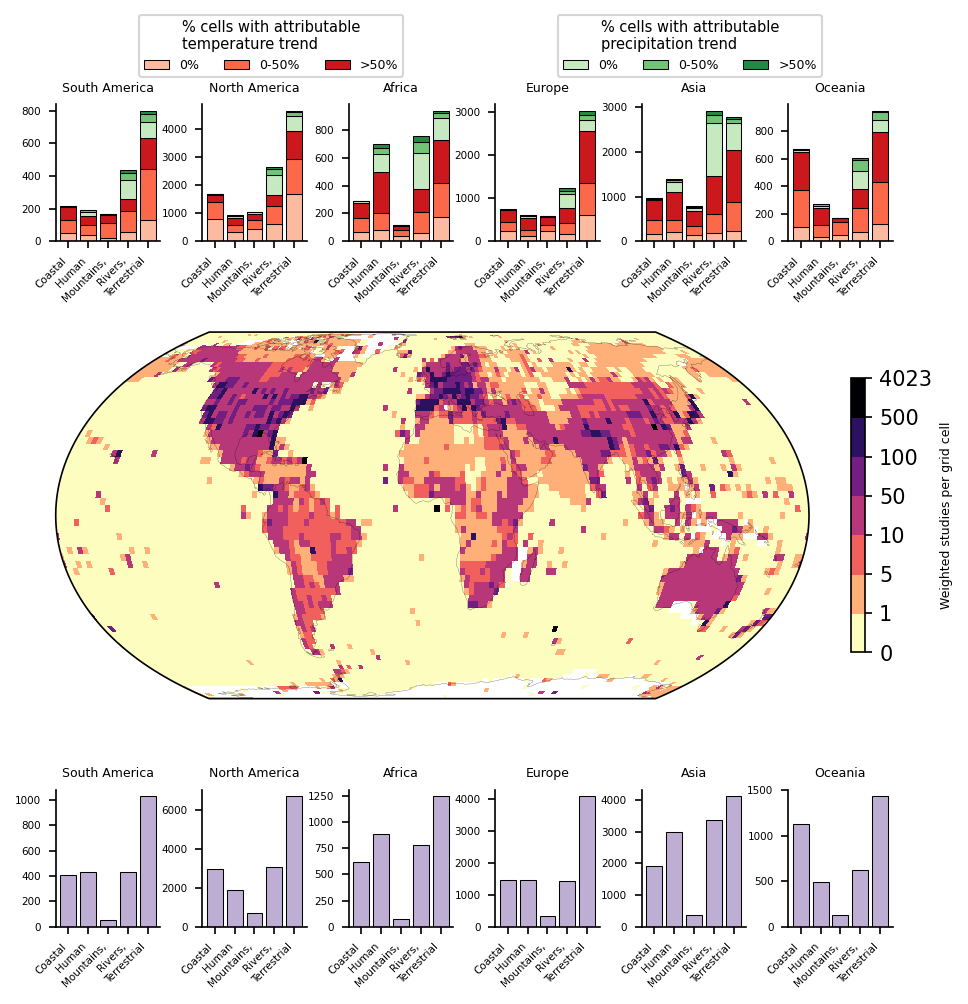

In [9]:
fig = plt.figure(dpi=150,figsize=(7.2,6.5))

gs = gridspec.GridSpec(4, 6, height_ratios=[.1, .25, 1, .25], bottom=.05, top=.95, wspace=.4, hspace=0.0)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

bounds = np.array([0,1,5,10,50,100,500,vm])

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X,
    Y,
    n,
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
    #cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="vertical", fraction=0.05, pad=0.05, ax=ax, shrink=0.5)

cbar.set_label("Weighted studies per grid cell", fontsize=6)
#cbar.ax.tick_params(labelsize=6)

#############################
##
    
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    r = regions[ci]
    a = plt.subplot(gs[1,ci])
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    
    vdf = df[df["id"].isin(group["doc_id"])]
    
    for i, col in enumerate(sector_cols):

        b = 0
        all_handles = []
        for j, da_var in enumerate(["Temperature","Precipitation"]):

            cm = mpl.cm.get_cmap(colors[j])

            cdf = vdf[(vdf[col]>0.5) & (vdf["da_var"]==da_var) ]

            y = cdf[cdf['da_trend_p']==0].shape[0]
            l1 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw,color=cm(0.25))   
            b+=y

            y = cdf[(cdf['da_trend_p']>0) & (cdf['da_trend_p']<0.5)].shape[0]
            l2 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.5))    
            b+=y

            y = cdf[(cdf['da_trend_p']>0.5)].shape[0]
            l3 = a.bar(i, y, bottom=b, edgecolor="black",lw=lw, color=cm(0.75))  
            b+=y
            
            var_handles = [l1,l2,l3]
            all_handles.append(var_handles)
            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=6)        
    a.tick_params(axis='both', which='major', labelsize=5)
    
    # Other docs
    a = plt.subplot(gs[3,ci])
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    
    vdf = cat_df[(cat_df["id"].isin(group["doc_id"])) & (cat_df['tp']==True)]
    
    for i, col in enumerate(sector_cols):

        b = 0
        cm = mpl.cm.get_cmap(colors[j])        
        y = vdf[vdf[col]>=0.5].shape[0]        
        a.bar(i, y, color="#beaed4", ec="black", lw=0.5)

            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=6)        
    a.tick_params(axis='both', which='major', labelsize=5)
    
    
ax = plt.subplot(gs[0,:])

attrib_labels = [
    "0%",
    "0-50%",
    ">50%"
]

l0 = ax.legend(
    all_handles[0], attrib_labels, 
    loc=(.1,0.5),
    fontsize=6,
    ncol=3
)    
l0.set_title("% cells with attributable\ntemperature trend", prop={'size':7})
l1 = ax.legend(
    all_handles[1], 
    attrib_labels, 
    loc=(0.6,0.5),
    fontsize=6,
    ncol=3
)    
l1.set_title("% cells with attributable\nprecipitation trend", prop={'size':7})

plt.gca().add_artist(l0)
ax.axis("off")

South America
(0.32, 0.35)
North America
(0.3, 0.8)
Africa
(0.5, 0.6)
Europe
(0.52, 0.85)
Asia
(0.75, 0.75)
Oceania
(0.87, 0.33)


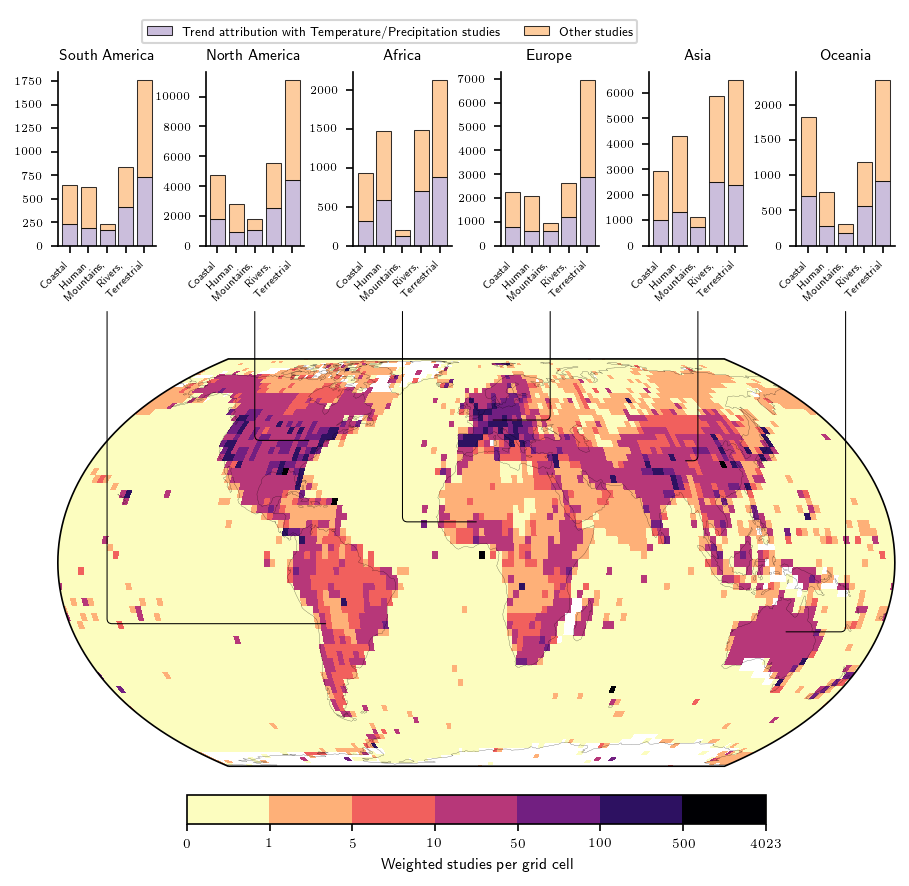

In [16]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch, ConnectionStyle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.5

cols = 2

fig = plt.figure(dpi=150,figsize=(7.2,6))

gs = gridspec.GridSpec(3, 6, height_ratios=[.1, .3, 1,], bottom=.05, top=.95, wspace=.5, hspace=0.00)

ax = plt.subplot(gs[2, :], projection=ccrs.EqualEarth())

ndf.loc[ndf['LON']>180,"LON"]-=360

n = np.array(ndf.n_study_prop).reshape(len(ndf.LAT.unique()), len(ndf.LON.unique()))
vm = n.max()
n[n==0] = np.nan

ax.coastlines(lw=0.1)
mesh = ax.pcolormesh(
    X,
    Y,
    n,
    
    norm = mpl.colors.BoundaryNorm(bounds,256),
    #cmap=plt.cm.get_cmap('YlOrBr',vm/3-1), 
    #cmap = "YlOrBr",
    cmap = "magma_r",
#     norm = mpl.colors.LogNorm(vmin=0.1, vmax=vm),
#     cmap=plt.cm.get_cmap('YlOrBr',12), 
    transform=ccrs.PlateCarree(),
    #shading="gouraud"
)
cbar = plt.colorbar(mesh, orientation="horizontal", fraction=0.05, pad=0.05)

cbar.set_label("Weighted studies per grid cell", fontsize=7)
cbar.ax.tick_params(labelsize=6)

continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

continent_labels = [
    (0.32,0.35),
    (0.3,0.8),
    (0.5,0.6),
    (0.52,0.85),
    (0.75,0.75),
    (0.87,0.33),
]

#for ci, (continent, group) in enumerate(places.groupby('continent')):
    
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    r = regions[ci]
    a = plt.subplot(gs[1,ci])
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    
    xy = (0.5, -0.38)
    
    mxy = continent_labels[ci]
    print(mxy)
    con = ConnectionPatch(xyA=xy, coordsA=a.transAxes,
                          xyB=mxy, coordsB=ax.transAxes,
                          connectionstyle=ConnectionStyle.Angle(angleA=90, rad=5),
                          linewidth=0.5
                         )
    fig.add_artist(con)

    
    vdf = cat_df[cat_df["id"].isin(group["doc_id"])]
    
    bcs = ['#beaed4','#fdc086']
    all_handles = []
    
    for i, col in enumerate(sector_cols):

        b = 0
        
        for j, (name, group) in enumerate(vdf.groupby("tp")):
            y = group[group[col]>=0.5].shape[0]
            bar = a.bar(i, y, bottom=b, color=bcs[j], alpha=0.8, lw=0.5, ec="black")
            if i==0:
                all_handles.append(bar)
            b+=y

            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(sector_cols)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)
    
ax = plt.subplot(gs[0,:])


# attrib_labels = [
#     "0%",
#     "0-50%",
#     ">50%"
# ]

l0 = ax.legend(
    all_handles, ["Trend attribution with Temperature/Precipitation studies","Other studies"], 
    loc=(.1,0.5),
    fontsize=6,
    ncol=2
)    
# l0.set_title("% cells with attributable\ntemperature trend", prop={'size':7})
# l1 = ax.legend(
#     all_handles[1], 
#     attrib_labels, 
#     loc=(0.6,0.5),
#     fontsize=6,
#     ncol=3
# )    
# l1.set_title("% cells with attributable\nprecipitation trend", prop={'size':7})

# plt.gca().add_artist(l0)
ax.axis("off")
    
plt.savefig('../figures/figure_3.png', dpi=300, bbox_inches="tight")
plt.savefig('../figures/figure_3.svg', bbox_inches="tight")
plt.savefig('../figures/figure_3.pdf', bbox_inches="tight")

In [12]:
(cat_df[cat_df['2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction']>0.5]
 .sort_values('0 - relevance - mean_prediction',ascending=False)
 .title.values[4]
)

'West Africa climate extremes and climate change indices'

In [13]:
(cat_df[cat_df['2 - 2.4. Sensitivity - mean_prediction']>0.5]
 .sort_values('0 - relevance - mean_prediction',ascending=False)
 .title.values[1]
)

'Acute effect of daily mean temperature on ischemic heart disease mortality: a multivariable meta-analysis from 12 counties across Hubei Province, China'

In [14]:
(cat_df[cat_df['2 - Trend or climate change attribution - mean_prediction']>0.5]
 .sort_values('0 - relevance - mean_prediction',ascending=False)
 .title.values[2]
)

'Delayed phenology and reduced fitness associated with climate change in a wild hibernator'

# Get the specific impact categories now

In [22]:
import re

extra_cat_df = pd.read_csv('../data/1_predicted_category_documents_specific.csv')

specific_impact_cats = [x for x in extra_cat_df.columns if "18 -" in x and "mean" in x]

extra_cat_df = extra_cat_df[["id"]+[x for x in extra_cat_df.columns if "18 - " in x] ]

df = cat_df.merge(extra_cat_df, how="outer")

print(df.shape)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")
table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])

impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1

specific_impacts = [
    '18 - Terrestrial Water Cycle - mean_prediction',
    '18 - Drought & Floods - mean_prediction',
    '18 - Cryosphere - mean_prediction',
    '18 - Coastal and marine Ecosystems - mean_prediction',
    '18 - Terrestrial ES - mean_prediction',
    #'18 - Carbon Cycle - mean_prediction',
    '18 - Wildfires - mean_prediction',
    '18 - Food/Agriculture - mean_prediction',
    '18 - Livelihoods and wellbeing - mean_prediction',
    '18 - Health - mean_prediction',
    '18 - Displacement and migration - mean_prediction',
    #'18 - Other anthropogenic - mean_prediction'
]

for c in specific_impacts:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())

(120265, 285)
13153.186978795382
13299.186978795382
6179.329707313106
6241.329707313106
5015.571211510866
5088.571211510866
9326.325412233688
9395.325412233688
36547.6434056815
36822.6434056815
1463.682673722669
1493.682673722669
4423.2415895870945
4476.2415895870945
6349.4681782291955
6397.5492830151
6091.917419718631
6216.917419718631
1817.8905208962026
1849.1316340895667


South America
North America
Africa
Europe
Asia
Oceania


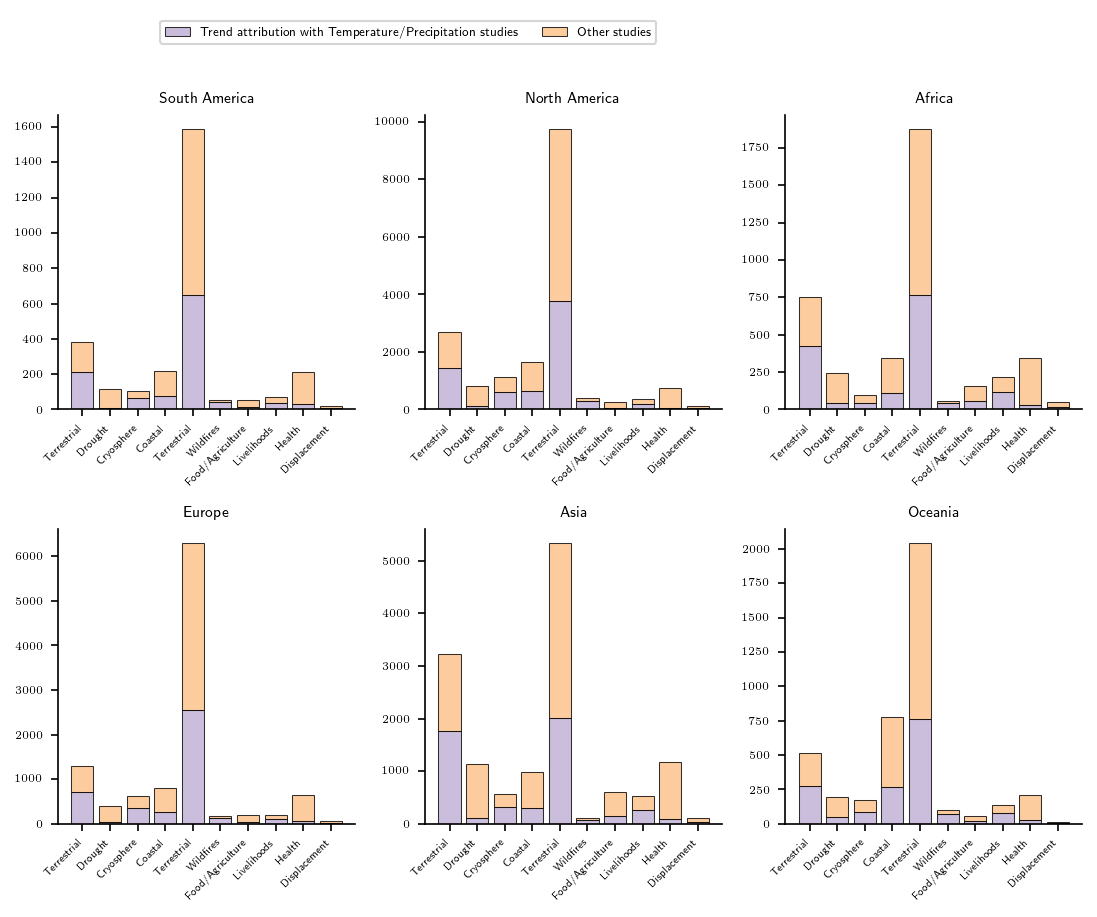

In [42]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch, ConnectionStyle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.5

cols = 2

fig = plt.figure(dpi=150,figsize=(7.2,6), constrained_layout=True)

gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[0.2,1,1])

continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

sharey=None
  
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    
    if sharey is None:
        a = plt.subplot(gs[ci//3+1,ci%3])
        sharey = None
    else: 
        a = plt.subplot(gs[ci//3+1,ci%3], sharey=sharey)
    
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
        
    vdf = df[df["id"].isin(group["doc_id"])]
    
    bcs = ['#beaed4','#fdc086']
    all_handles = []
    
    for i, col in enumerate(specific_impacts):

        b = 0
        
        for j, (name, group) in enumerate(vdf.groupby("tp")):
            y = group[group[col]>=0.5].shape[0]
            bar = a.bar(i, y, bottom=b, color=bcs[j], alpha=0.8, lw=0.5, ec="black")
            if i==0:
                all_handles.append(bar)
            b+=y

            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(specific_impacts)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)
    
    #a.set_yscale('log')
    
    if ci==0:
        ax = plt.subplot(gs[0,:])
        l0 = ax.legend(
            all_handles, ["Trend attribution with Temperature/Precipitation studies","Other studies"], 
            loc=(.1,0.5),
            fontsize=6,
            ncol=2
        )  
        ax.axis('off')
    
    
plt.savefig('../figures/si_figure_3.png', dpi=300, bbox_inches="tight")
plt.savefig('../figures/si_figure_3.svg', bbox_inches="tight")
plt.savefig('../figures/si_figure_3.pdf', bbox_inches="tight")

South America
North America
Africa
Europe
Asia
Oceania


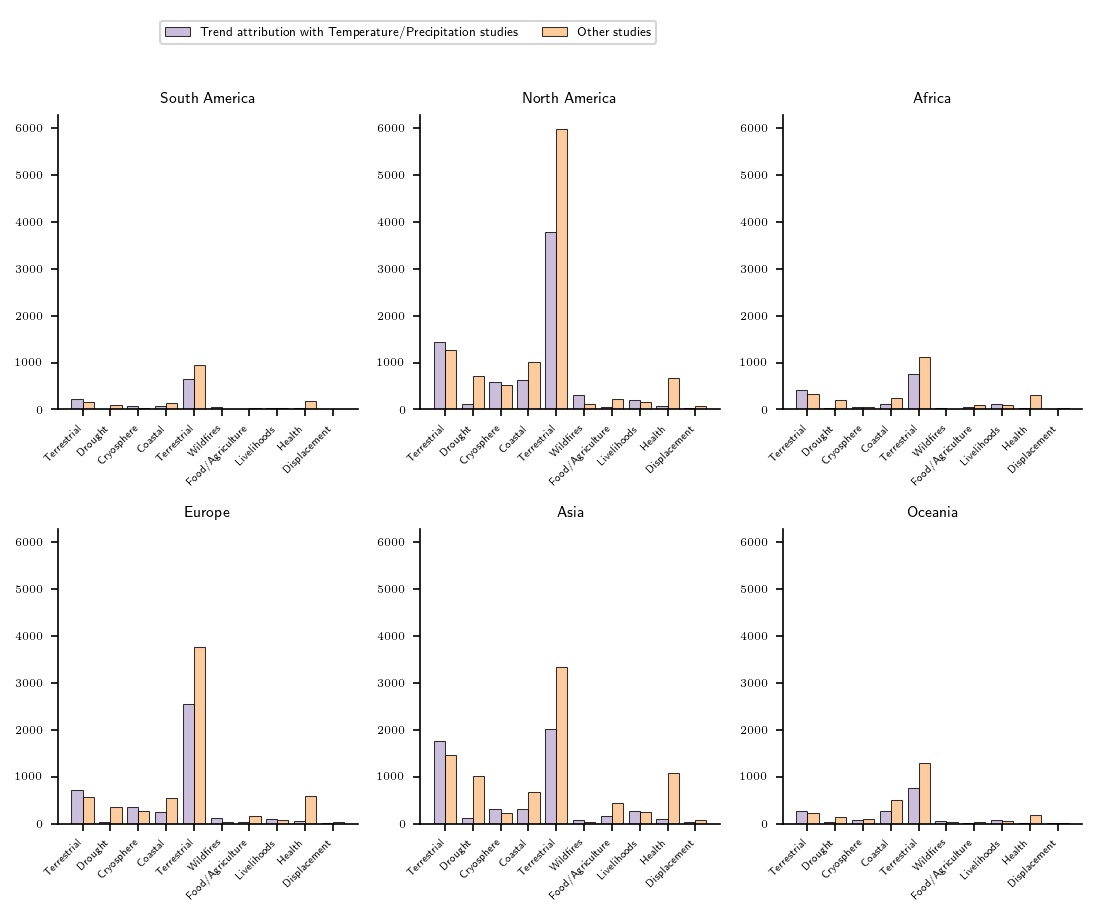

In [47]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch, ConnectionStyle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.5

cols = 2

fig = plt.figure(dpi=150,figsize=(7.2,6), constrained_layout=True)

gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[0.2,1,1])

continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

sharey=None
  
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    
    if sharey is None:
        a = plt.subplot(gs[ci//3+1,ci%3])
        sharey = a
    else: 
        a = plt.subplot(gs[ci//3+1,ci%3], sharey=sharey)
    
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
        
    vdf = df[df["id"].isin(group["doc_id"])]
    
    bcs = ['#beaed4','#fdc086']
    all_handles = []
    
    for i, col in enumerate(specific_impacts):

        b = 0
        
        for j, (name, group) in enumerate(vdf.groupby("tp")):
            y = group[group[col]>=0.5].shape[0]
            bar = a.bar(i-0.2+j*0.4, y, color=bcs[j], alpha=0.8, lw=0.5, ec="black",width=0.4)
            if i==0:
                all_handles.append(bar)
            b+=y

            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(specific_impacts)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)
    
    #a.set_yscale('log')
    
    if ci==0:
        ax = plt.subplot(gs[0,:])
        l0 = ax.legend(
            all_handles, ["Trend attribution with Temperature/Precipitation studies","Other studies"], 
            loc=(.1,0.5),
            fontsize=6,
            ncol=2
        )  
        ax.axis('off')
    
    
plt.savefig('../figures/si_figure_3.png', dpi=300, bbox_inches="tight")
plt.savefig('../figures/si_figure_3.svg', bbox_inches="tight")
plt.savefig('../figures/si_figure_3.pdf', bbox_inches="tight")

South America
North America
Africa
Europe
Asia
Oceania


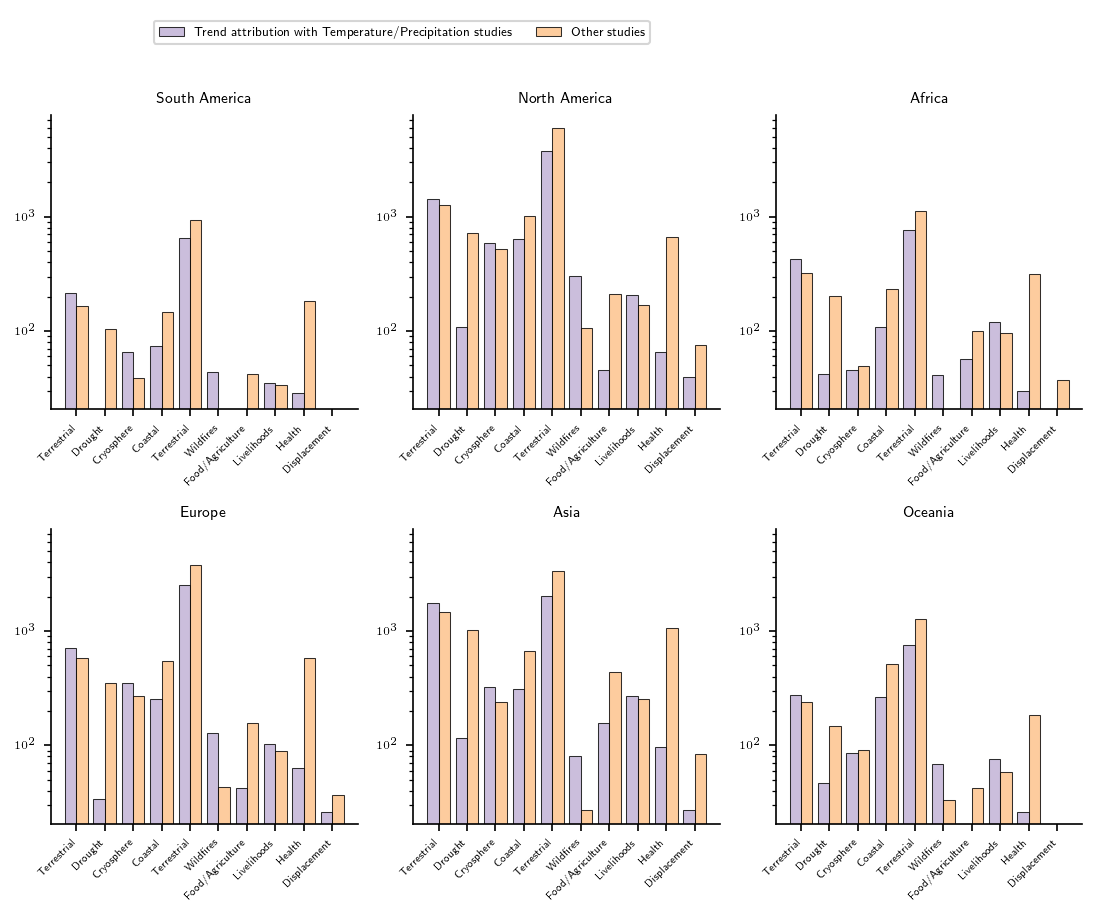

In [48]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch, ConnectionStyle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

colors = ["Reds","Greens","Oranges","Purples","Reds","PuRd","YlGnBu"]

lw = 0.5

cols = 2

fig = plt.figure(dpi=150,figsize=(7.2,6), constrained_layout=True)

gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[0.2,1,1])

continents = [
    "South America", 
    "North America", 
    "Africa", 
    "Europe", 
    "Asia",
    "Oceania"
]

sharey=None
  
for ci, continent in enumerate(continents):
    group = places[places["continent"]==continent]
    print(continent)
    
    if sharey is None:
        a = plt.subplot(gs[ci//3+1,ci%3])
        sharey = a
    else: 
        a = plt.subplot(gs[ci//3+1,ci%3], sharey=sharey)
    
    a.set_facecolor("none")
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
        
    vdf = df[df["id"].isin(group["doc_id"])]
    
    bcs = ['#beaed4','#fdc086']
    all_handles = []
    
    for i, col in enumerate(specific_impacts):

        b = 0
        
        for j, (name, group) in enumerate(vdf.groupby("tp")):
            y = group[group[col]>=0.5].shape[0]
            bar = a.bar(i-0.2+j*0.4, y, color=bcs[j], alpha=0.8, lw=0.5, ec="black",width=0.4)
            if i==0:
                all_handles.append(bar)
            b+=y

            
    ticks, ticklabels = zip(*[(i, x.split(' - ')[1].split()[0]) for i, x in enumerate(specific_impacts)])
    a.set_xticks(ticks)
    a.set_xticklabels(ticklabels, rotation=45, ha="right")
        
    a.set_title(continent, fontsize=7)
        
    a.tick_params(axis='both', which='major', labelsize=5)
    
    a.set_yscale('log')
    
    if ci==0:
        ax = plt.subplot(gs[0,:])
        l0 = ax.legend(
            all_handles, ["Trend attribution with Temperature/Precipitation studies","Other studies"], 
            loc=(.1,0.5),
            fontsize=6,
            ncol=2
        )  
        ax.axis('off')
    
    
plt.savefig('../figures/si_figure_3.png', dpi=300, bbox_inches="tight")
plt.savefig('../figures/si_figure_3.svg', bbox_inches="tight")
plt.savefig('../figures/si_figure_3.pdf', bbox_inches="tight")